Data Processing was done in seperate notebook. 

Link: https://colab.research.google.com/drive/1vTeJih_4oFFz3IWBR3rLCcwWPdgrrtcf 

# Baseline Model

## Image Classifier (AlexNet)

In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

AlexNet


In [ ]:
# alexnet

alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def find_classes(dir):
  classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
  classes.sort()
  class_to_idx = {classes[i]: i for i in range(len(classes))}
  return classes, class_to_idx

In [ ]:
#kaggle data + google images
!unzip '/content/drive/MyDrive/THIRD YEAR U of T/APS360 Project/Just Apparel Renamed.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7004.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7005.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7006.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7007.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7008.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7009.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7010.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7011.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7012.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7013.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7014.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7015.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Short

In [ ]:
# Data Loading
def get_data_loader(batch_size=64,overfit = False):
    """ 
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    classes = find_classes("/root/datasets/Just Apparel Renamed") 
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    
    transform = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    if overfit == False:
      raw_dataset = torchvision.datasets.ImageFolder("/root/datasets/Just Apparel Renamed"
      , transform=transform)

    #else:
    #  raw_dataset = torchvision.datasets.ImageFolder("/content/drive/My Drive/check_overfit_handgesture", transform=transform) 

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    indices = np.arange(len(raw_dataset))
    np.random.shuffle(indices)
    train_split = int(len(indices) * 0.8)

    # dividing by 2 will assign 10% to val and 10% to test
    # if the train is 0.8
    testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
    

    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split], indices[testval_split:]   

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader,classes


In [ ]:
#Get Data Loaders
train_loader, val_loader, test_loader,classes = get_data_loader(batch_size = 1)

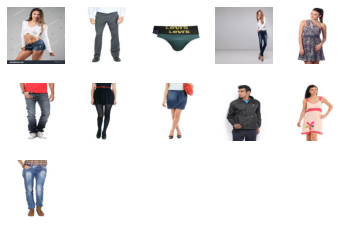

In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 10:
        break

In [ ]:
batch_size = 1
print("Training examples:", len(train_loader)*batch_size)
print("Validation examples:", len(val_loader)*batch_size)
print("Test examples:", len(test_loader)*batch_size)

Training examples: 9600
Validation examples: 1199
Test examples: 1201


In [ ]:
len(train_loader.dataset)

12000

AlexNet Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

torch.manual_seed(1) # set the random seed


# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


torch.Size([1, 256, 6, 6])

Define New Classifier

In [ ]:
#new bottom layers for AlexNet
class BaselineClassifier(nn.Module):
    def __init__(self):
        super(BaselineClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6,50)
        self.fc2 = nn.Linear(50, 12)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(model, data_loader):
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(ALNC(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def get_model_path(name, batch_size, num_epochs,learning_rate):
    return "{}_bs{}_epoch{}_lr{}".format(name,batch_size,num_epochs,learning_rate)


In [ ]:
def train(model, batch_size=64, num_epochs=30, learning_rate = 0.01):

    train_loader, val_loader, test_loader,classes = get_data_loader(batch_size)
    
    use_cuda = True                                       
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
          
            out = model(ALNC(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Best training results

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.26  % Time Elapsed:   4.39 s 
Iteration:  2 Progress:   0.53  % Time Elapsed:   7.79 s 
Iteration:  3 Progress:   0.79  % Time Elapsed:  11.18 s 
Iteration:  4 Progress:   1.05  % Time Elapsed:  14.57 s 
Iteration:  5 Progress:   1.32  % Time Elapsed:  17.99 s 
Iteration:  6 Progress:   1.58  % Time Elapsed:  21.52 s 
Iteration:  7 Progress:   1.84  % Time Elapsed:  24.93 s 
Iteration:  8 Progress:   2.11  % Time Elapsed:  28.33 s 
Iteration:  9 Progress:   2.37  % Time Elapsed:  31.77 s 
Iteration:  10 Progress:   2.63  % Time Elapsed:  35.32 s 
Iteration:  11 Progress:   2.89  % Time Elapsed:  38.79 s 
Iteration:  12 Progress:   3.16  % Time Elapsed:  42.27 s 
Iteration:  13 Progress:   3.42  % Time Elapsed:  45.80 s 
Iteration:  14 Progress:   3.68  % Time Elapsed:  49.25 s 
Iteration:  15 Progress:   3.95  % Time Elapsed:  52.63 s 
Iteration:  16 Progress:   4.21  % Time Elapsed:  56.16 s 
Iteration:  17 Progress: 

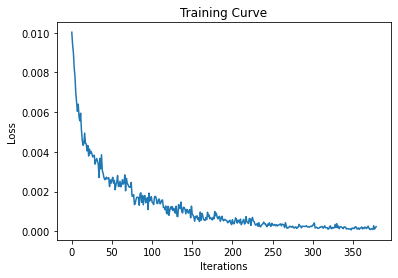

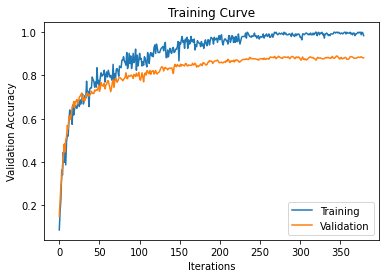

Final Training Accuracy: 0.9967708333333334
Final Validation Accuracy: 0.8815679733110926
Total time:   1300.49 s  Time per Epoch:  130.05 s 


In [ ]:
#with 50 hidden units
model = BaselineClassifier()
ALNC = alexNet.features
use_cuda = True

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#train model
train(model, batch_size=256, learning_rate=0.01, num_epochs=10)

Final Training Accuracy: 0.9967708333333334
Final Validation Accuracy: 0.8815679733110926

In [ ]:
#save the trained model
model_path = get_model_path("BaselineNew2", 256, 10, 0.01)
torch.save(model.state_dict(), model_path)

Load best model & get test accuracy 

In [ ]:
#with 50 hidden units
model = BaselineClassifier()
ALNC = alexNet.features
use_cuda = True

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()

baseline_path = get_model_path("BaselineNew2", 256, 10, 0.01)
state = torch.load(baseline_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
train_loader, val_loader, test_loader,classes = get_data_loader(batch_size = 256)
get_accuracy(model,test_loader)

0.9125728559533722

# Primary Model: Fashion Recommendation Model

## Image Classifier (Resnet50)

In [ ]:
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

import time
import os
import numpy as np
import torch


In [ ]:
def find_classes(dir):
  classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
  classes.sort()
  class_to_idx = {classes[i]: i for i in range(len(classes))}
  return classes, class_to_idx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/THIRD YEAR U of T/APS360 Project/Just Apparel Renamed.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7004.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7005.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7006.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7007.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7008.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7009.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7010.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7011.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7012.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7013.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7014.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Shorts_7015.jpg  
  inflating: /root/datasets/Just Apparel Renamed/Shorts/Short

In [ ]:

def get_data_loader(batch_size=64,overfit = False):
    """ 
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    
    classes = find_classes("/root/datasets/Just Apparel Renamed") 
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    
    transform = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    if overfit == False:
      
      raw_dataset = torchvision.datasets.ImageFolder("/root/datasets/Just Apparel Renamed", transform=transform)

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    indices = np.arange(len(raw_dataset))
    np.random.shuffle(indices)
    train_split = int(len(indices) * 0.8)

    testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
    

    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split], indices[testval_split:]   

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader,classes

In [ ]:
def get_model_path(name, batch_size, num_epochs,learning_rate):
    return "{}_bs{}_epoch{}_lr{}".format(name,batch_size,num_epochs,learning_rate)

Train code

In [ ]:
def get_accuracy_dropout(model, data_loader):
    
	#when you call this make sure you pass in the correct data_loader
    correct = 0
    total = 0
    model.eval()

    for imgs, labels in data_loader: #added iter() around data_loader
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        out = model(imgs)
        
        #select index with maximum prediction score
        _,pred = torch.max(out, dim=1)
        correct += torch.sum(pred==labels).item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def faster_train_dropout(model, batch_size=64, num_epochs=10, learning_rate = 0.01, weight_decay=0):

    train_loader, val_loader, test_loader,classes = get_data_loader(batch_size)
    
    use_cuda = True                                       
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    epochs, iters, losses, train_acc, val_acc = [], [], [], [], []

    # training
    n=0
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        
        correct = 0
        total_train_loss = 0
        total = 0
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            model.train()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


          # save the current training information
 
            mini_b += 1
            n+=1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))

        #get accuracy for this epoch
        epochs.append(epoch+1)
        losses.append(float(loss)/batch_size)        # compute *average* loss
        train_acc.append(get_accuracy_dropout(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy_dropout(model, val_loader))   # compute validation accuracy


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Training")
    plt.plot(epochs, val_acc, label="Validation")    
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    #train_acc.append(get_accuracy_dropout(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Best training results

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.05  % Time Elapsed:   0.89 s 
Iteration:  2 Progress:   0.11  % Time Elapsed:   0.96 s 
Iteration:  3 Progress:   0.16  % Time Elapsed:   1.33 s 
Iteration:  4 Progress:   0.21  % Time Elapsed:   1.72 s 
Iteration:  5 Progress:   0.27  % Time Elapsed:   2.11 s 
Iteration:  6 Progress:   0.32  % Time Elapsed:   2.50 s 
Iteration:  7 Progress:   0.37  % Time Elapsed:   2.89 s 
Iteration:  8 Progress:   0.43  % Time Elapsed:   3.28 s 
Iteration:  9 Progress:   0.48  % Time Elapsed:   3.67 s 
Iteration:  10 Progress:   0.53  % Time Elapsed:   4.05 s 
Iteration:  11 Progress:   0.59  % Time Elapsed:   4.44 s 
Iteration:  12 Progress:   0.64  % Time Elapsed:   4.83 s 
Iteration:  13 Progress:   0.69  % Time Elapsed:   5.22 s 
Iteration:  14 Progress:   0.75  % Time Elapsed:   5.61 s 
Iteration:  15 Progress:   0.80  % Time Elapsed:   6.00 s 
Iteration:  16 Progress:   0.85  % Time Elapsed:   6.39 s 
Iteration:  17 Progress:

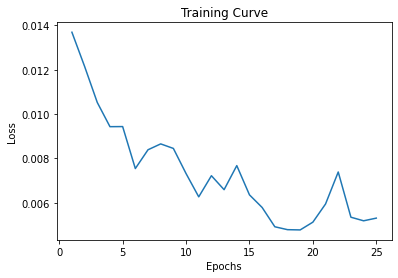

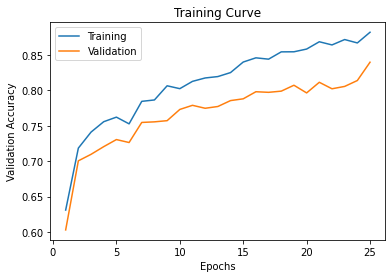

Final Training Accuracy: 0.8821875
Final Validation Accuracy: 0.8398665554628857
Total time:   1648.96 s  Time per Epoch:  65.96 s 


In [ ]:
resnet50_6 = torchvision.models.resnet50(pretrained=True)
for param in resnet50_6.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet50_6.fc.in_features
resnet50_6.fc = nn.Sequential( nn.Dropout(0.4), nn.Linear(num_ftrs, 1024), nn.ReLU(),nn.BatchNorm1d(1024), nn.Dropout(0.4), nn.Linear(1024, 12) )

use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
  resnet50_6 = resnet50_6.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')

#or you can run this instead
faster_train_dropout(resnet50_6, batch_size=128,num_epochs=25, learning_rate=0.05 )

In [ ]:
model_path = get_model_path("resnet50_6_dropout", 128, 25, 0.05)
torch.save(resnet50_6.state_dict(), model_path)

Load best model and get test accuracy

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential( nn.Dropout(0.4), nn.Linear(num_ftrs, 1024), nn.ReLU(),nn.BatchNorm1d(1024), nn.Dropout(0.4), nn.Linear(1024, 12) )


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
#upload the pretrained model to the workspace
#resnet50_6_dropout_bs128_epoch25_lr0.05

resnet50_path = get_model_path("resnet50_6_dropout", 128, 25, 0.05)
state = torch.load(resnet50_path)
resnet50.load_state_dict(state)


<All keys matched successfully>

In [ ]:
resnet50.cuda()

predictions: ['Skirts', 'Tshirts', 'Leggings', 'One-piece', 'Pants']
labels: ['Skirts', 'Shirts', 'Leggings', 'One-piece', 'Pants']


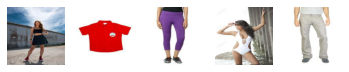

In [ ]:
#visualize example predictions
train_loader, val_loader, test_loader,classes = get_data_loader(batch_size = 5)

classes = find_classes("/root/datasets/Just Apparel Renamed")[0] 

dataiter = iter(val_loader) 
images, labels = dataiter.next()

#visualize those 10 photos
k=0
for img in images:
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(img, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    k+=1

out = resnet50(images)
#print(out)

_,pred = torch.max(out, dim=1)

print("predictions:", [classes[i] for i in pred])
print("labels:", [classes[i] for i in labels])

mini_batch_correct = torch.sum(pred==labels).item()
Mini_batch_total = images.shape[0]

Test Accuracy: 81.5 %

In [ ]:
use_cuda = True
get_accuracy_dropout(resnet50,test_loader)

0.8151540383014155

In [ ]:
#New dataset class to use instead of ImageFolder
#source: https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/3
from torch.utils.data import Dataset
import natsort

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

Helper functions for using our model on new data with no labels (from Demo)

In [ ]:
def demo_img_loader(batch_size):
    #can be used for new data with no labels, all in one folder 
    transform = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    #change path name
    img_folder_path = "/content/drive/MyDrive/THIRD YEAR U of T/APS360 Project/Demo_imgs/Jeans"
    my_dataset = CustomDataSet(img_folder_path, transform=transform)
    data_loader = torch.utils.data.DataLoader(my_dataset , batch_size=batch_size,num_workers=1)   
    
    return data_loader

#upload the best model 
def load_img_classifier():
    resnet50 = torchvision.models.resnet50(pretrained=True)
    for param in resnet50.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = resnet50.fc.in_features
    resnet50.fc = nn.Sequential( nn.Dropout(0.4), nn.Linear(num_ftrs, 1024), nn.ReLU(),nn.BatchNorm1d(1024), nn.Dropout(0.4), nn.Linear(1024, 12) )

    resnet50_path = get_model_path("resnet50_6_dropout", 128, 25, 0.05)
    state = torch.load(resnet50_path)
    resnet50.load_state_dict(state)

    return resnet50
def plot_images(images):
    k=0
    for img in images:
        img = np.transpose(img, [1,2,0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 5, k+1)
        plt.axis('off')
        plt.imshow(img)
        k+=1

def predict_and_evaluate(model, images, labels):
    #get model predictions on a mini batch
    model.eval()

    out = model(images)

    _,pred = torch.max(out, dim=1)

    #print predictions
    print("predictions:", [classes[i] for i in pred])
    print("labels:", [classes[i] for i in labels])

    #Accuracy
    mini_batch_correct = torch.sum(pred==labels).item()
    print("mini batch correct:", mini_batch_correct)
    Mini_batch_total = images.shape[0]
    print("acc", (mini_batch_correct / Mini_batch_total))


Demo Code

In [ ]:
#here we should load our test images instead
data_loader = demo_img_loader(3)

classes = find_classes("/content/drive/MyDrive/THIRD YEAR U of T/APS360 Project/Demo_imgs")[0] 

resnet50 = load_img_classifier()

dataiter = iter(data_loader) 
images, labels = dataiter.next()

#visualize those photos
plot_images(images)

#get model predictions
predict_and_evaluate(resnet50, images, labels)

## Recommendation Model 

### Encoder

Separating encoder and decoder approach

In [ ]:
class convEncoder_smaller(nn.Module):
  def __init__(self):
    super(convEncoder_smaller, self).__init__()
    self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=6, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=6, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 40, 7)
      )
  def forward(self, x):
    x = self.encoder(x)
    return x
  
class convDecoder_smaller(nn.Module):
  def __init__(self):
    super(convDecoder_smaller, self).__init__()
    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(40, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=6, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=6, padding=1, output_padding=1),
            nn.Sigmoid()
      )

  def forward(self, x):
    x = self.decoder(x)
    return x

In [ ]:
def train(encoder,decoder, train_loader,val_loader,num_epochs=5, batch_size=64, learning_rate=1e-3,subscript=""):
    #https://medium.com/pytorch/image-similarity-search-in-pytorch-1a744cf3469
    torch.manual_seed(32)
    if torch.cuda.is_available():
      encoder = encoder.cuda()
      decoder = decoder.cuda()
      print('CUDA is available!  Training on GPU ...')
    else:
      print('CUDA is not available.  Training on CPU ...')

    criterion = nn.MSELoss() # mean square error loss
    '''
    autoencoder_params = list(encoder.parameters())+list(decoder.parameters())

    optimizer = torch.optim.Adam(autoencoder_params,
                                 lr=learning_rate, 
                                 weight_decay=1e-5) 
    '''
    optimizer_encoder = torch.optim.Adam(encoder.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    optimizer_decoder = torch.optim.Adam(decoder.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    outputs = []
    start_time=time.time()
    best = 10
    for epoch in range(num_epochs):
        #print("enter loop")
        for data in train_loader:
            img, _ = data
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              img = img.cuda()
            #############################################
            #print('Start autoencoder') 
            embedding = encoder(img)
            #print('end encoder')
            recon = decoder(embedding)
            #print('end decoder')
            #img = img.view(-1, 3*224*224)
            loss = criterion(recon, img)
            #print('loss computed')
            loss.backward()
            optimizer_encoder.step()
            optimizer_decoder.step()
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            '''
            optimizer.step()
            optimizer.zero_grad()
            '''
        if loss < best:
          best = loss
          #save the trained model
          model_path = get_model_path("C_encoder_smaller"+subscript, batch_size, num_epochs,learning_rate)
          torch.save(encoder.state_dict(), model_path)
          #save the trained model
          model_path = get_model_path("C_decoder_smaller"+subscript, batch_size, num_epochs,learning_rate)
          torch.save(decoder.state_dict(), model_path)
          print("updated")

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

        outputs.append((epoch, img, recon),)

    end_time= time.time()
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    return outputs


In [ ]:
def get_model_path(name, batch_size, num_epochs,learning_rate):
    director = "/content/drive/MyDrive/Industrial Engineering 3rd year - Jihoon Chung/Winter/APS360 Project/saved model states/"
    return director+"{}_bs{}_epoch{}_lr{}".format(name,batch_size,num_epochs,learning_rate)

In [ ]:
C_encoder = convEncoder()
C_decoder = convDecoder()

outputs = train(C_encoder,C_decoder,train_loader,val_loader)

CUDA is available!  Training on GPU ...
updated
Epoch:1, Loss:0.1187
updated
Epoch:2, Loss:0.0963
updated
Epoch:3, Loss:0.0959
updated
Epoch:4, Loss:0.0888
Epoch:5, Loss:0.0940
Total time:   2720.01 s  Time per Epoch:  544.00 s 


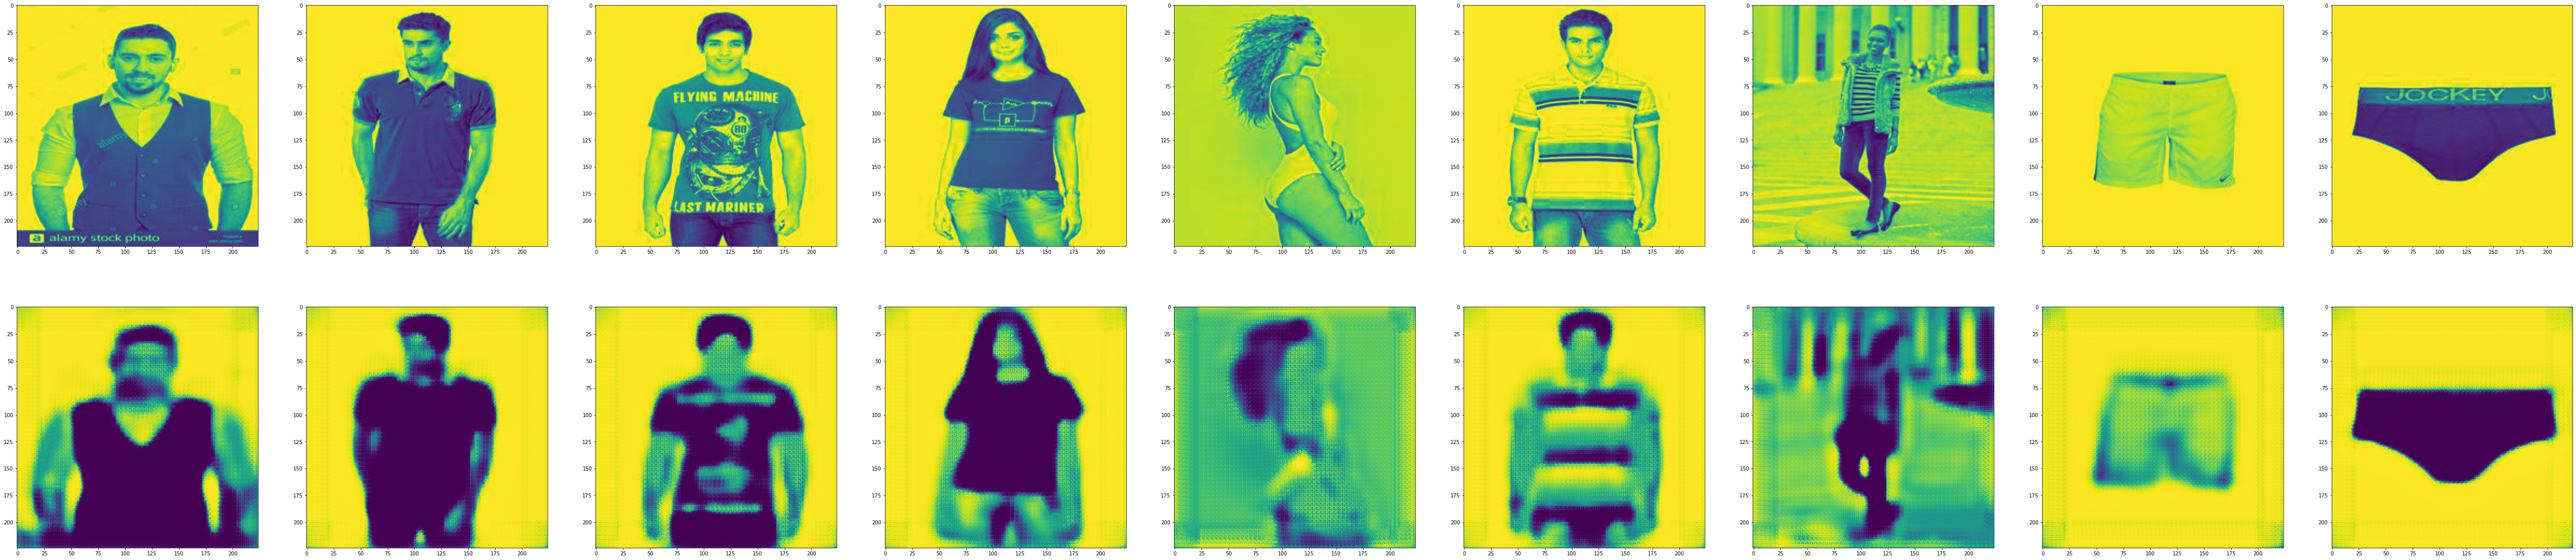

In [ ]:
# reconstructed images at various parts of training

for k in range(0, 5, 5):
    plt.figure(figsize=(90, 20))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Save embeddings

In [ ]:
# Get data loader with all images
def get_all_data_loader(batch_size=64,overfit = False):
    
    transform = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    if overfit == False:
      raw_dataset = torchvision.datasets.ImageFolder("/root/datasets/Just Apparel Sampled New"
      , transform=transform)
    
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling

    data_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    
    
    return data_loader

In [ ]:
def create_embedding(encoder):
  directory = '/content/drive/MyDrive/Industrial Engineering 3rd year - Jihoon Chung/Winter/APS360 Project/Embeddings/'
  
  data_loader = get_all_data_loader()

  if torch.cuda.is_available():
      encoder = encoder.cuda()
      print('CUDA is available!')
  else:
      print('CUDA is not available.')
  # Just a place holder for our 0th image embedding.
  #embedding = torch.randn(embedding_dim)
  start_time=time.time()
  data_loader = get_all_data_loader(1)

  filename_list = []

  for item in data_loader.dataset.imgs:
    path = item[0].split('/')
    filename = path[-1] #then, remove .jpg from that file name and save that name somewhere
    filename = filename.split('.')[0]
    filename_list.append(filename)
  

  for i, item in enumerate(data_loader):
    img, label = item
    #############################################
    #To Enable GPU Usage
    if torch.cuda.is_available():
      img = img.cuda()
    #############################################
    embedding = encoder(img).cpu()
    for j in label:
      numpy_em = embedding.squeeze(0).detach().numpy()
      torch.save(numpy_em[int(j)], directory + str(classes[0][int(j)]) + '/' + filename_list[i] + '.npy')


In [ ]:
create_embedding(C_encoder_smaller)

CUDA is available!
Time:  9.5367431640625e-07 ; loader:  1

0 th batch done: 1.1782972812652588

1 th batch done: 1.8422293663024902

2 th batch done: 2.6290407180786133

3 th batch done: 3.4011478424072266

4 th batch done: 4.171414136886597

5 th batch done: 4.9575722217559814

6 th batch done: 5.63242506980896

7 th batch done: 6.4022908210754395

8 th batch done: 7.181670427322388

9 th batch done: 7.960515022277832

10 th batch done: 8.62760877609253

11 th batch done: 9.396393537521362

12 th batch done: 10.19891905784607

13 th batch done: 10.954988718032837

14 th batch done: 11.618299007415771

15 th batch done: 12.38711404800415

16 th batch done: 13.169808626174927

17 th batch done: 13.827369451522827

18 th batch done: 14.632546663284302

19 th batch done: 15.396711111068726

20 th batch done: 16.173346281051636

21 th batch done: 16.819393157958984

22 th batch done: 17.60105800628662

23 th batch done: 18.379608869552612

24 th batch done: 19.03196120262146

25 th batch 

### KNN

In [ ]:
def load_data():
    sourceDir = 'C:\\Users\\Stephen\\Documents\\APS360\\Project\\Demo\\Embed'
    dataset = {}
    for i in os.scandir(sourceDir):
        binName = i.path.split('\\')[-1]
        dataset[binName] = {}
        for j in os.scandir(i.path):
            imageName = j.path.split('\\')[-1].split('.')[0]
            dataset[binName][imageName] = torch.load(j.path)
    return dataset

def clean_list(data):
    last = 0
    newData = []
    for i in data:
        if i[0] != last:
            newData.append(i)
            last = i[0]
    return newData

def neighbor(v1, bin, data):
    v1 = v1.flatten()
    close = 1000
    distances = []
    for key in data[bin].keys():
        v2 = data[bin][key].flatten()
        dist = np.linalg.norm(v1-v2)
        if dist != 0:
            distances.append([dist, key, v2])
    distances.sort(key=lambda x:x[0])
    distances = clean_list(distances)
    return distances

def neighbor_neighbor(data, k):
    distances = []
    for entry in data[:k-1]:
        distTotal = 0
        for compare in data[:k-1]:
            dist = np.linalg.norm(entry[0]-compare[0])
            distTotal += dist
        distances.append([distTotal, entry[1]])
    distances.sort(key=lambda x:x[0])
    distances = clean_list(distances)
    return distances    

def match(embed, binName, dataset, k = 10, top = 3):
    testArray = torch.load(embed)
    imageName = embed.split('\\')[-1].split('.')[0] + '.jpg'
    inputDir = 'C:\\Users\\Stephen\\Documents\\APS360\\Project\\Demo\\Input JPG\\'
    imageDir = 'C:\\Users\\Stephen\\Documents\\APS360\\Project\\KNN\\Just Apparel Renamed\\'
    distances = neighbor(testArray, binName, dataset)
    distances_distances = neighbor_neighbor(distances, k)
    
    print('Original', imageName)
    pil_im = Image.open(inputDir + '\\' + imageName)
    pil_im = pil_im.resize((224,224))
    display(pil_im)
    for i in range(top):
        print('Match: ', (distances[i][1] + '.jpg'))
        pil_im = Image.open(imageDir + binName + '\\' + distances[i][1] + '.jpg')
        print(distances[i][0])
        display(pil_im)

testDir = 'C:\\Users\\Stephen\\Documents\\APS360\\Project\\KNN\\Test Embed'

for test in os.scandir(testDir):
    match(test.path, dataset, k = 10, top = 2)
    print('-'*50)